In [1]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100%|██████████████████████████████████████▉| 1.03G/1.04G [00:07<00:00, 209MB/s]
100%|███████████████████████████████████████| 1.04G/1.04G [00:07<00:00, 158MB/s]


In [2]:
!unzip flickr8k.zip -d /content/


Archive:  flickr8k.zip
  inflating: /content/Images/1000268201_693b08cb0e.jpg  
  inflating: /content/Images/1001773457_577c3a7d70.jpg  
  inflating: /content/Images/1002674143_1b742ab4b8.jpg  
  inflating: /content/Images/1003163366_44323f5815.jpg  
  inflating: /content/Images/1007129816_e794419615.jpg  
  inflating: /content/Images/1007320043_627395c3d8.jpg  
  inflating: /content/Images/1009434119_febe49276a.jpg  
  inflating: /content/Images/1012212859_01547e3f17.jpg  
  inflating: /content/Images/1015118661_980735411b.jpg  
  inflating: /content/Images/1015584366_dfcec3c85a.jpg  
  inflating: /content/Images/101654506_8eb26cfb60.jpg  
  inflating: /content/Images/101669240_b2d3e7f17b.jpg  
  inflating: /content/Images/1016887272_03199f49c4.jpg  
  inflating: /content/Images/1019077836_6fc9b15408.jpg  
  inflating: /content/Images/1019604187_d087bf9a5f.jpg  
  inflating: /content/Images/1020651753_06077ec457.jpg  
  inflating: /content/Images/1022454332_6af2c1449a.jpg  
  inflatin

In [3]:
import os
import re
import numpy as np
import pandas as pd
import pickle
import spacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input , Dense , Embedding , LSTM , Dropout , add
from nltk.translate.bleu_score import corpus_bleu 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

In [18]:
BASE_DIR = '/content'
WORKING_DIR = '/kaggle/working/'

In [5]:
# Load pretrained model
feature_extractor = VGG16()
# Restructure the model
feature_extractor = Model(inputs = feature_extractor.inputs, outputs = feature_extractor.layers[-2].output)

feature_extractor.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Extract features from images
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size = (224,224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0],image.shape[1],image.shape[2]))
    # Preprocess image for vgg
    image = preprocess_input(image)
    # Extract features
    feature = feature_extractor.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    features[image_id] = feature.squeeze()

print(f"Extracted features for {len(features)} images.")

  0%|          | 0/8091 [00:00<?, ?it/s]

Extracted features for 8091 images.


In [9]:
feature_extractor.save('feature_extractor.h5')

In [11]:
feature_extractor.save('feature_extractor.keras')

In [21]:
 # Store features in pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [22]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as file:
    features = pickle.load(file)

In [27]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions = f.read()

In [28]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions.split('\n')):
    # Split the line by comma
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert capion list to string
    caption = ' '.join(caption)
    # Check for image id 
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [29]:
# Show samples
for image_id in list(mapping.keys())[:2]:
    print(image_id)
    print('\n'.join(mapping[image_id]))
    print('-'*50)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .
--------------------------------------------------
1001773457_577c3a7d70
A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .
A black dog and a white dog with brown spots are staring at each other in the street .
Two dogs of different breeds looking at each other on the road .
Two dogs on pavement moving toward each other .
--------------------------------------------------


In [30]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [31]:
# Perform cleaning
clean(mapping)

In [32]:
# Show sample 
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [33]:
captions = [caption for key in mapping for caption in mapping[key]]
len(captions)

40455

In [34]:
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [35]:
# Tokenize the text 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
print(f'The length of vocab is {vocab_size}')

The length of vocab is 8485


In [36]:
# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [37]:
# get maximum length 
max_length = max(len(caption.split()) for caption in captions)
max_length

35

In [38]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [39]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                # Tokenize the caption
                sequence = tokenizer.texts_to_sequences([caption])[0]
                # Split into input-output pairs
                for i in range(1, len(sequence)):
                    in_seq, out_seq = sequence[:i], sequence[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # One-hot encode output
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Store
                    X1.append(features[key])
                    X2.append(in_seq)
                    y.append(out_seq)
                    if n == batch_size:
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0

In [40]:
# Encode 
# Image features layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder1 = add([fe2 ,se3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 35)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4096)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │      2,172,160 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 35, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 35)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8485)           │      2,180,645 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

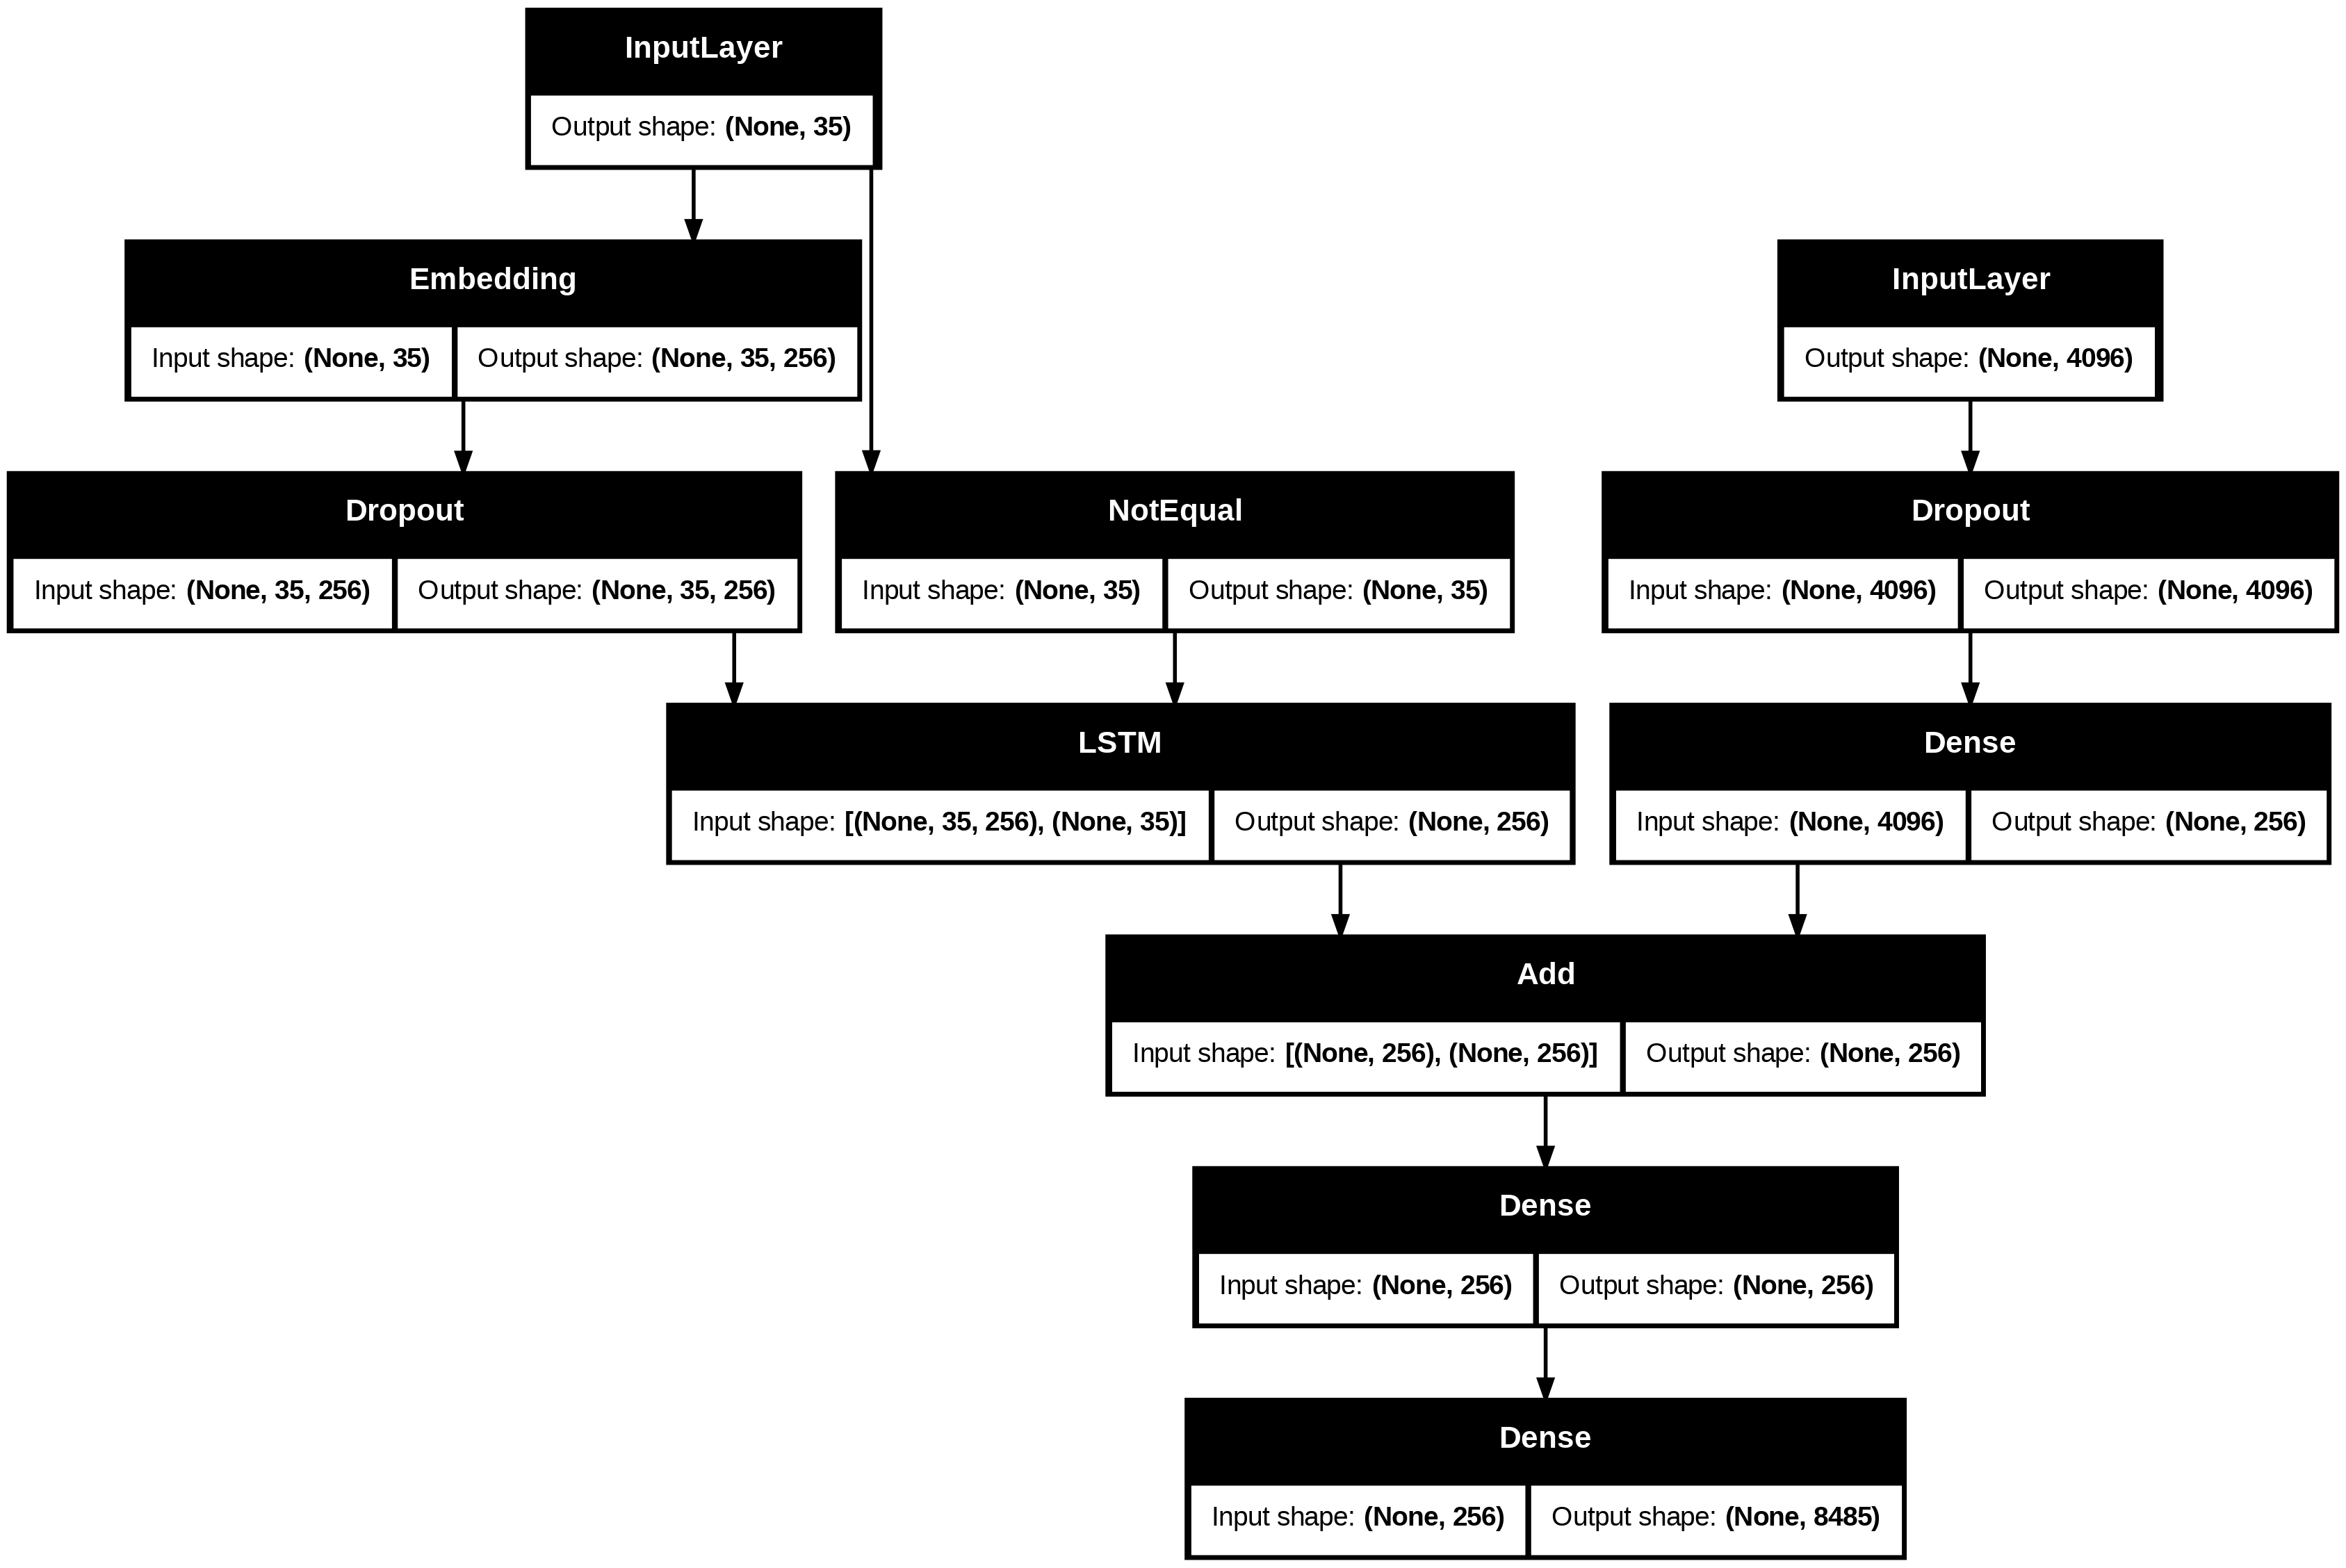

In [41]:
# Plot the model
plot_model(model, show_shapes = True)

In [42]:
# Define the output signature
output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)

# Create dataset function
def create_dataset(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size),
        output_signature=output_signature
    )
    return dataset

In [43]:
# Training parameters
epochs = 35
batch_size = 32
steps = len(train) // batch_size

# Create and train
train_dataset = create_dataset(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    model.fit(train_dataset, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - loss: 5.7771
Epoch 2/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - loss: 4.0577
Epoch 3/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 200ms/step - loss: 3.5779
Epoch 4/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 3.2985
Epoch 5/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - loss: 3.0935
Epoch 6/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - loss: 2.9374
Epoch 7/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 45s 199ms/step - loss: 2.8248
Epoch 8/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.7293
Epoch 9/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 202ms/step - loss: 2.6462
Epoch 10/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.5718
Epoch 11/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.5135
Epoch 12/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - loss: 2.4536
Epoch 13/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 43s 191ms/step - loss: 2.4096
Epoch 14/35
227/227 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 2.3612
Epoch 15/35
227

In [44]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [45]:
model.save(WORKING_DIR+'/best_model.keras')

In [46]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [47]:
def predict_caption(model, image, tokenizer, max_length):
    # Add batch dimension to image features
    image = np.expand_dims(image, axis=0)  # Shape: (1, 4096)
    
    # Start with 'startseq'
    in_text = 'startseq'
    for i in range(max_length):
        # Encode and pad the sequence (right-padding)
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post') 
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0) 
        yhat = np.argmax(yhat)
        
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        
        # Append word to input text
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [48]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.531624
BLEU-2: 0.307431


In [49]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
--------------------Predicted--------------------
startseq man in red shirt is standing in front of skyscraper endseq


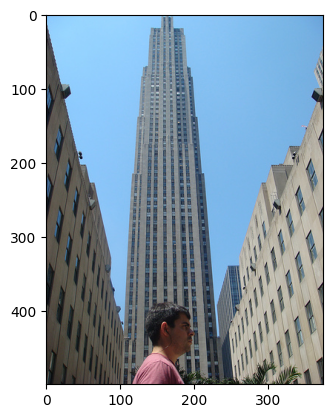

In [50]:
generate_caption('1032460886_4a598ed535.jpg')

---------------------Actual---------------------
startseq man in black is sitting next to modern art structure in front of glass building endseq
startseq man sits and reads newspaper by sculpture outside of an office building endseq
startseq man sits near large statue endseq
startseq man sitting in front of metal sculpture in front of building endseq
startseq the man with the backpack is sitting in buildings courtyard in front of an art sculpture reading endseq
--------------------Predicted--------------------
startseq man is using large stick to modern large black and black dog endseq


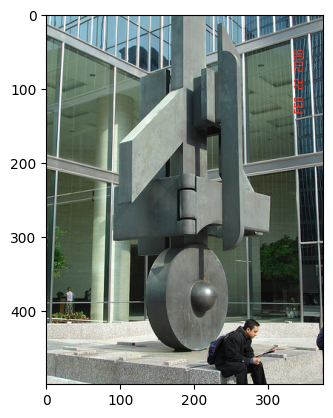

In [51]:
generate_caption('103195344_5d2dc613a3.jpg')